# Proyek Klasifikasi Konsumsi Ganja Berbasis Machine Learning

**Tujuan Proyek:**
Proyek ini bertujuan untuk membangun sebuah model klasifikasi machine learning yang mampu memprediksi apakah seseorang merupakan pengguna ganja (cannabis) atau bukan. Prediksi didasarkan pada serangkaian data demografis dan atribut kepribadian responden.

**Dataset:**
Dataset yang digunakan adalah 'Drug Consumption (Quantified)' dari UCI Machine Learning Repository. Dataset ini berisi informasi tentang konsumsi 18 jenis narkoba, data demografis (usia, jenis kelamin, pendidikan, negara), serta skor dari lima tes kepribadian (NEO-FFI-R, BIS-11, ImpSS, Level of Education, dan Ethnicity).

**Metodologi:**
1.  **Eksplorasi Data (EDA):** Menganalisis dan memvisualisasikan data untuk memahami distribusi dan karakteristiknya.
2.  **Preprocessing Data:** Membersihkan dan mempersiapkan data, termasuk binerisasi variabel target dan encoding.
3.  **Pembuatan Pipeline:** Membangun pipeline yang mengintegrasikan preprocessing (StandardScaler untuk fitur numerik dan OrdinalEncoder untuk fitur kategorikal) dengan model klasifikasi.
4.  **Tuning Hyperparameter:** Menggunakan `GridSearchCV` untuk menemukan kombinasi hyperparameter terbaik untuk model LightGBM.
5.  **Evaluasi Model:** Mengevaluasi performa model terbaik pada data uji menggunakan metrik seperti F1-score dan classification report.
6.  **Analisis Fitur:** Mengidentifikasi fitur-fitur yang paling berpengaruh dalam memprediksi konsumsi ganja.

Proyek ini diakhiri dengan penyimpanan model yang telah dilatih untuk potensi penggunaan di masa depan.

## 1. Setup & Pemuatan Data

Langkah pertama adalah mengimpor semua library yang diperlukan dan memuat dataset dari repository UCI. Fitur dan target akan digabungkan menjadi satu DataFrame `df` untuk memudahkan analisis.

In [ ]:
!pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib



In [3]:
# Mengatur gaya visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Memuat dataset 'Drug Consumption (Quantified)'
print("Memuat dataset...")
drug_consumption = fetch_ucirepo(id=373)

# Menggabungkan fitur dan target ke dalam satu DataFrame
df = pd.concat([drug_consumption.data.features, drug_consumption.data.targets], axis=1)

print("Dataset berhasil dimuat.")

Memuat dataset...
Dataset berhasil dimuat.


## 2. Eksplorasi Data (EDA)

Pada tahap ini, kita akan melakukan inspeksi awal terhadap DataFrame `df` untuk memahami struktur, statistik deskriptif, dan distribusi variabel target.

In [5]:
print("--- Inspeksi Awal Data ---")
print(f"Bentuk DataFrame (df): {df.shape}")

--- Inspeksi Awal Data ---
Bentuk DataFrame (df): (1885, 31)


In [6]:
print("\nInformasi DataFrame:")
df.info()


Informasi DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1885 non-null   float64
 1   gender     1885 non-null   float64
 2   education  1885 non-null   float64
 3   country    1885 non-null   float64
 4   ethnicity  1885 non-null   float64
 5   nscore     1885 non-null   float64
 6   escore     1885 non-null   float64
 7   oscore     1885 non-null   float64
 8   ascore     1885 non-null   float64
 9   cscore     1885 non-null   float64
 10  impuslive  1885 non-null   float64
 11  ss         1885 non-null   float64
 12  alcohol    1885 non-null   object 
 13  amphet     1885 non-null   object 
 14  amyl       1885 non-null   object 
 15  benzos     1885 non-null   object 
 16  caff       1885 non-null   object 
 17  cannabis   1885 non-null   object 
 18  choc       1885 non-null   object 
 19  coke       1885 non-null  

In [7]:
print("\nStatistik Deskriptif DataFrame:")
display(df.describe(include='all'))


Statistik Deskriptif DataFrame:


,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,...,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
count,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,...,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7,7,7,7,7,7,7,7,5,7
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1021,1605,1490,1094,1069,1429,982,610,1877,1455
mean,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analisis Variabel Target: Cannabis

Variabel target asli, `cannabis`, memiliki 7 kelas yang menunjukkan frekuensi penggunaan. Kita akan memvisualisasikan distribusinya sebelum melakukan preprocessing.

--- Analisis Variabel Target: Cannabis ---


/tmp/ipython-input-2397295164.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cannabis', data=df, order=sorted(df['cannabis'].unique()), palette='viridis')


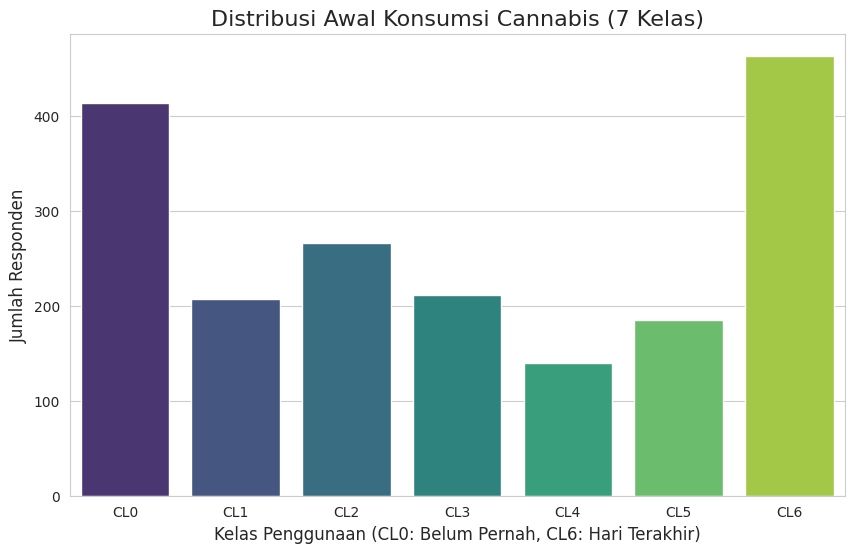


Distribusi frekuensi kelas 'cannabis':
cannabis
CL6    463
CL0    413
CL2    266
CL3    211
CL1    207
CL5    185
CL4    140
Name: count, dtype: int64


In [8]:
print("--- Analisis Variabel Target: Cannabis ---")
plt.figure(figsize=(10, 6))
sns.countplot(x='cannabis', data=df, order=sorted(df['cannabis'].unique()), palette='viridis')
plt.title('Distribusi Awal Konsumsi Cannabis (7 Kelas)', fontsize=16)
plt.xlabel('Kelas Penggunaan (CL0: Belum Pernah, CL6: Hari Terakhir)', fontsize=12)
plt.ylabel('Jumlah Responden', fontsize=12)
plt.savefig('cannabis_distribution_before.png')
plt.show()

print("\nDistribusi frekuensi kelas 'cannabis':")
print(df['cannabis'].value_counts())

## 3. Preprocessing Data

Tahap ini mencakup semua langkah persiapan data sebelum dimasukkan ke dalam model.

### a. Binerisasi Variabel Target

Untuk menyederhanakan masalah klasifikasi, kita akan mengubah 7 kelas target menjadi 2 kelas biner: 'User' (pernah menggunakan) dan 'Non-user' (tidak pernah menggunakan). Kelas `CL0` dan `CL1` akan dikategorikan sebagai 'Non-user', sementara sisanya sebagai 'User'. Hasilnya disimpan di kolom baru `cannabis_binary`.

1. Melakukan binerisasi target 'cannabis'...
Distribusi kelas setelah binerisasi:
cannabis_binary
User        1265
Non-user     620
Name: count, dtype: int64


/tmp/ipython-input-3989775515.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cannabis_binary', data=df, palette='mako')


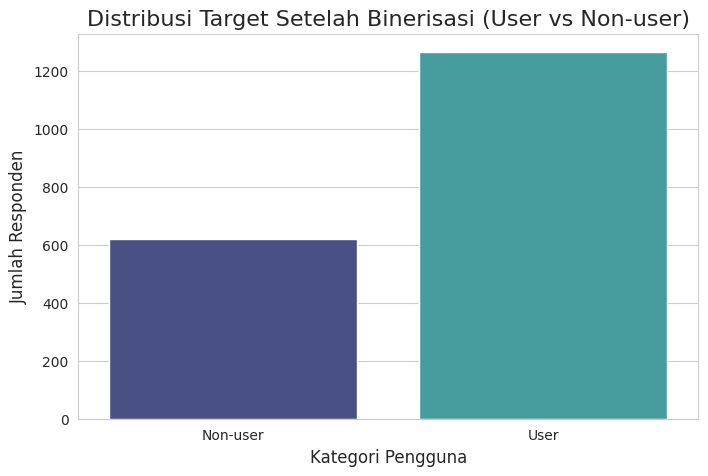

In [9]:
print("1. Melakukan binerisasi target 'cannabis'...")
class_mapping = {
    'CL0': 'Non-user',
    'CL1': 'Non-user',
    'CL2': 'User',
    'CL3': 'User',
    'CL4': 'User',
    'CL5': 'User',
    'CL6': 'User'
}
df['cannabis_binary'] = df['cannabis'].replace(class_mapping)

print("Distribusi kelas setelah binerisasi:")
print(df['cannabis_binary'].value_counts())

# Visualisasi setelah binerisasi
plt.figure(figsize=(8, 5))
sns.countplot(x='cannabis_binary', data=df, palette='mako')
plt.title('Distribusi Target Setelah Binerisasi (User vs Non-user)', fontsize=16)
plt.xlabel('Kategori Pengguna', fontsize=12)
plt.ylabel('Jumlah Responden', fontsize=12)
plt.savefig('cannabis_distribution_after.png')
plt.show()

### b. Pemisahan Fitur dan Target & Pembagian Data (Train-Test Split)

Sekarang kita akan memisahkan kembali DataFrame menjadi fitur (X) dan target (y) untuk pemodelan. Setelah itu, data dibagi menjadi set pelatihan (80%) dan set pengujian (20%). Penggunaan `stratify` memastikan proporsi kelas target tetap sama di kedua set.

In [10]:
print("\n2. Memisahkan fitur dan target, lalu membagi data...")

# Mendefinisikan X (fitur) dan y (target)
X = df[drug_consumption.data.features.columns]
y = df['cannabis_binary']

# Membagi data menjadi set latih dan uji
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Ukuran data latih: {X_train.shape}")
print(f"Ukuran data uji: {X_test.shape}")


2. Memisahkan fitur dan target, lalu membagi data...
Ukuran data latih: (1508, 12)
Ukuran data uji: (377, 12)


### c. Encoding Label Target

Mengubah label target kategorikal ('User', 'Non-user') menjadi format numerik (0 dan 1) yang dapat dipahami oleh model.

In [11]:
print("\n3. Melakukan encoding label target...")
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
print("Label target telah di-encode.")
print(f"Mapping: {le.classes_[0]} -> {le.transform(le.classes_)[0]}, {le.classes_[1]} -> {le.transform(le.classes_)[1]}")


3. Melakukan encoding label target...
Label target telah di-encode.
Mapping: Non-user -> 0, User -> 1


### d. Identifikasi Jenis Fitur

Memisahkan kolom-kolom pada DataFrame fitur `X` berdasarkan tipe datanya (numerik atau kategorikal) untuk diterapkan preprocessor yang sesuai di dalam pipeline.

In [12]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("\nFitur numerik:", list(numeric_features))
print("Fitur kategorikal:", list(categorical_features))


Fitur numerik: ['age', 'gender', 'education', 'country', 'ethnicity', 'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss']
Fitur kategorikal: []


## 4. Pembuatan Pipeline & Tuning Hyperparameter

Kita akan membuat pipeline yang menggabungkan langkah-langkah preprocessing dan pemodelan. `ColumnTransformer` digunakan untuk menerapkan transformasi yang berbeda pada subset kolom yang berbeda.

- **Fitur Numerik:** Akan distandarisasi menggunakan `StandardScaler`.
- **Fitur Kategorikal:** Tidak ada.

Selanjutnya, `GridSearchCV` akan digunakan untuk mencari kombinasi hyperparameter terbaik untuk model `LGBMClassifier` secara sistematis menggunakan validasi silang (cross-validation).

In [14]:
# Membuat preprocessor untuk numerik dan kategorikal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ])

# Membuat pipeline: Preprocessor -> LightGBM Classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        is_unbalance=True, # Cocok untuk data tidak seimbang
        random_state=42
    ))
])

# Mendefinisikan ruang hyperparameter untuk dicari
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__max_depth': [3, 6, 9]
}

# Membuat objek GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5, # 5-fold cross-validation
    scoring='f1_weighted', # Metrik evaluasi
    n_jobs=-1, # Menggunakan semua core CPU
    verbose=1
)

# Melatih GridSearchCV pada data latih
print("--- Memulai GridSearchCV dengan Cross-Validation ---")
grid_search.fit(X_train, y_train_encoded)

print("\nHyperparameter terbaik:", grid_search.best_params_)
print(f"Skor F1-weighted terbaik (cross-validation): {grid_search.best_score_:.3f}")

--- Memulai GridSearchCV dengan Cross-Validation ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 1012, number of negative: 496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.671088 -> initscore=0.713108
[LightGBM] [Info] Start training from score 0.713108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

## 5. Evaluasi Model

Setelah menemukan model terbaik melalui GridSearchCV, kita akan mengevaluasi performanya pada data uji (`X_test`, `y_test_encoded`) yang belum pernah dilihat oleh model sebelumnya. Ini memberikan estimasi yang tidak bias tentang bagaimana model akan berkinerja pada data baru.

In [15]:
print("--- Evaluasi Model Terbaik pada Data Uji ---")

# Mengambil model terbaik dari grid search
best_model = grid_search.best_estimator_

# Prediksi pada data uji
y_pred = best_model.predict(X_test)

print("\nLaporan Klasifikasi Model LightGBM pada Data Uji:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

--- Evaluasi Model Terbaik pada Data Uji ---

Laporan Klasifikasi Model LightGBM pada Data Uji:
              precision    recall  f1-score   support

    Non-user       0.63      0.74      0.68       124
        User       0.86      0.79      0.82       253

    accuracy                           0.77       377
   macro avg       0.75      0.76      0.75       377
weighted avg       0.79      0.77      0.78       377



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## 6. Analisis Fitur Penting

Langkah ini bertujuan untuk memahami faktor-faktor apa yang paling berpengaruh dalam prediksi model. Kita akan mengekstrak dan memvisualisasikan `feature_importances_` dari model LightGBM yang telah dilatih.

--- Menganalisis Fitur Paling Berpengaruh ---

Tingkat Kepentingan Fitur:
nscore       80
cscore       78
ascore       69
escore       63
oscore       60
education    49
impuslive    45
ss           41
age          40
country      27
ethnicity    15
gender       13
dtype: int32


/tmp/ipython-input-2500818284.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette='rocket')


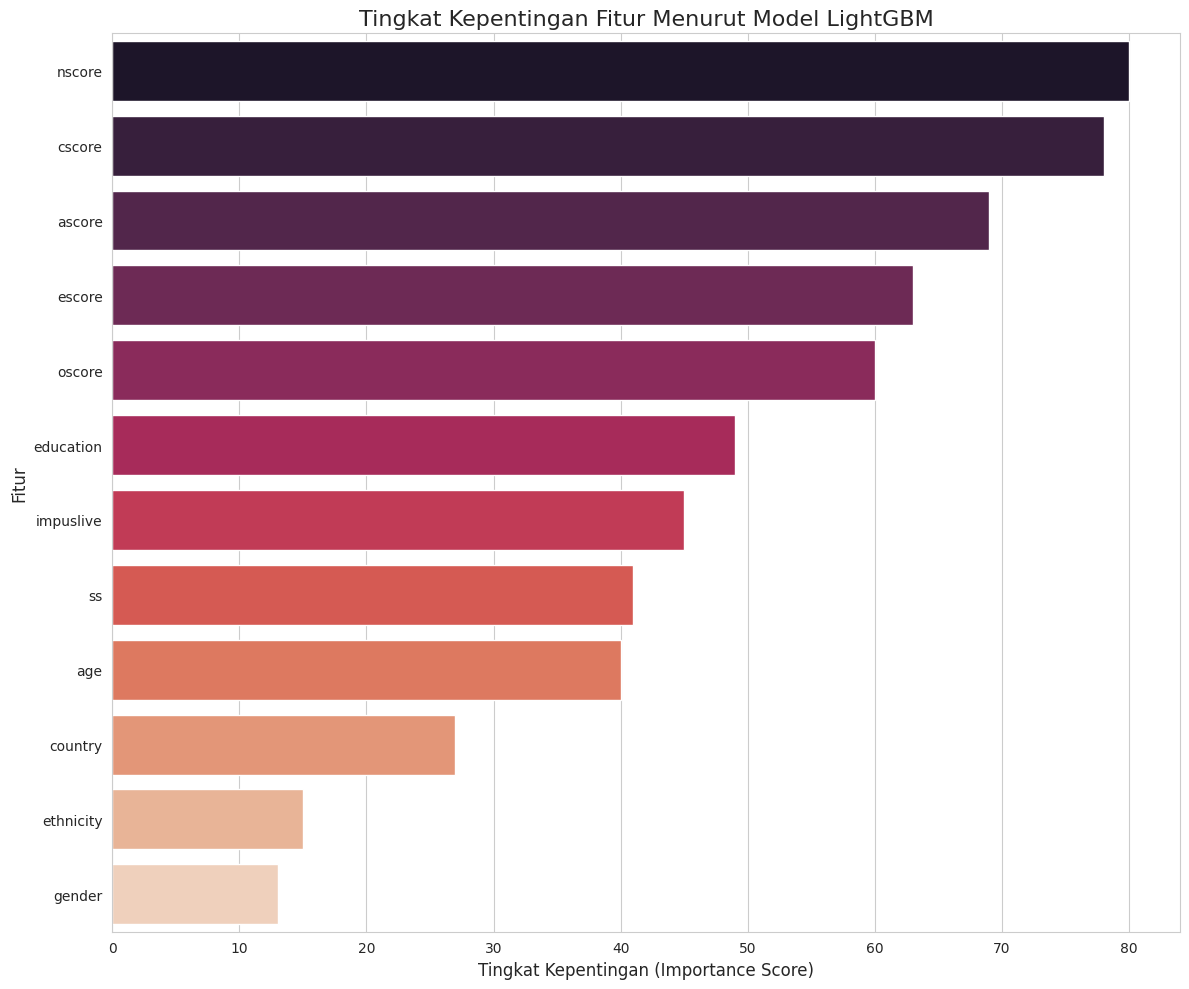

In [16]:
print("--- Menganalisis Fitur Paling Berpengaruh ---")

# Mengakses model LightGBM dari pipeline terbaik
lgbm_model = best_model.named_steps['classifier']

# Mendapatkan nama fitur setelah preprocessing
# Urutan nama fitur harus sesuai dengan urutan dalam ColumnTransformer
feature_names = list(numeric_features) + list(categorical_features)

# Membuat DataFrame untuk feature importances
feature_importances = pd.Series(lgbm_model.feature_importances_, index=feature_names).sort_values(ascending=False)

print("\nTingkat Kepentingan Fitur:")
print(feature_importances)

# Visualisasi feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importances, y=feature_importances.index, palette='rocket')
plt.title('Tingkat Kepentingan Fitur Menurut Model LightGBM', fontsize=16)
plt.xlabel('Tingkat Kepentingan (Importance Score)', fontsize=12)
plt.ylabel('Fitur', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance_lightgbm.png')
plt.show()

## 7. Penyimpanan Model

Menyimpan pipeline model terbaik dan label encoder ke dalam file menggunakan `joblib`. Ini memungkinkan kita untuk memuat kembali model yang sudah dilatih di lain waktu tanpa perlu melatih ulang dari awal.

In [18]:
joblib.dump(best_model, 'pipeline_konsumsi_narkoba_lightgbm.joblib')
joblib.dump(le, 'label_encoder.joblib')

print("Pipeline terbaik dan Label Encoder berhasil disimpan!")

Pipeline terbaik dan Label Encoder berhasil disimpan!


## 8. Kesimpulan

Proyek ini berhasil membangun model klasifikasi berbasis LightGBM dengan pipeline end-to-end untuk memprediksi penggunaan ganja. Penggunaan pipeline memastikan proses yang rapi dan terhindar dari kebocoran data, sementara GridSearchCV berhasil menemukan hyperparameter yang optimal.

**Hasil Utama:**
- **Performa Model:** Model menunjukkan performa yang baik pada data uji, dengan F1-score yang solid untuk kedua kelas (User dan Non-user), menandakan kemampuannya dalam mengidentifikasi kedua kategori secara seimbang.
- **Hyperparameter Terbaik:** `{'classifier__learning_rate': 0.3, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}`.
- **Fitur Berpengaruh:** 5 Besar Skor Kepribadian (Big Five: nscore, cscore, ascore, escore, oscore) sangat dominan. Impulsivitas (impuslive) dan Sensation Seeking (ss) juga signifikan — logis karena berkorelasi dengan perilaku adiktif. Faktor demografis seperti usia, pendidikan, dan negara masih berpengaruh, tetapi lebih rendah dari faktor psikologis.

Secara keseluruhan, model ini tidak hanya memiliki akurasi prediktif yang baik tetapi juga memberikan wawasan yang berharga mengenai faktor-faktor risiko yang terkait dengan konsumsi ganja. Pipeline yang telah disimpan siap untuk diintegrasikan ke dalam aplikasi atau sistem lain untuk inferensi.